In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dsdl
import numpy.random
from typing import Callable, List

%load_ext autoreload
%autoreload 2

In [2]:
DATASETS = ['a1a', 'mushrooms', 'a6a', 'w1a', 'w5a', 'ionosphere']
METHODS = ['SGD', 'AdaSpider', 'Spider', 'SpiderBoost', 'SVRG', 'AdaGrad', 'AdaSVRG']

# Logistic regression

In [3]:
from src.logistic_regression.log_reg_gradient import log_reg_gradient
from src.logistic_regression.sigmoid import sigmoid
from src.logistic_regression.stochastic_gradient import stochastic_gradient

from src.optimizers.Optimizer import Optimizer

In [4]:
def get_data(dataset_name: str):
    """
    :param dataset_name: Name of the dataset from dsdl module.
    :return: (X, y) train and target data.
    """
    ds = dsdl.load(dataset_name)
    X, y = ds.get_train()
    X = X.toarray()
    y = y.reshape(-1, 1)
    return X, y

def build_model(X, y):
    """
    Builds
    :param X: shape=(N, D). Train data
    :param y: shape=(N, 1). Target data
    :return: shape=(N, D+1). Built model for logistic regression.
    """
    return np.c_[np.ones((y.shape[0], 1)), X]

def get_initial_weights(tx):
    """
    Returns weights initialized from the uniform distribution [0, 1].
    :param tx: shape=(N, D). Build model
    :return: shape=(D, 1) Initial weights
    """
    return np.random.uniform(low=0, high=1, size=(tx.shape[1], 1))

def test_method(method: Optimizer,
                dataset_name: str,
                max_iter: int,
                *parameters) -> List:
        """
        :param method: Optimization method implementation from src optimizers module.
        :param dataset_name: Name of the dataset from dsdl module.
        :param max_iter: Number of iterations to test.
        :param parameters optional: Dataclass containing parameters used int optimization method.
        :return: List of gradients from optimization method.
        """
        X, y = get_data(dataset_name)
        tx = build_model(X, y)
        w = get_initial_weights(tx)
        return method.optimize(w, tx, y, max_iter)

In [5]:
from src.optimizers.SGD import SGD
from src.optimizers.AdaSpider import AdaSpider
from src.optimizers.Spider import Spider
from src.optimizers.SpiderBoost import SpiderBoost
from src.optimizers.SVRG import SVRG
from src.optimizers.AdaGrad import AdaGrad
from src.optimizers.AdaSVRG import AdaSVRG

In [16]:
METHODS = [
    SGD(lambda_=0.05),
    AdaSpider(),
    Spider(n_0 = 0.05, epsilon=0.005),
    SpiderBoost(),
    SVRG(q=100, lambda_=0.05),
    # AdaGrad(lambda_=0.05, epsilon= 0.005),
    AdaSVRG(q=100, lambda_=0.05)
]

### Plot

ionosphere
AdaGrad
[[0.587121  ]
 [0.89680278]
 [0.1002218 ]
 [0.48895382]
 [0.47714026]
 [0.42725705]
 [0.00099653]
 [0.73750847]
 [0.23553544]
 [0.75820231]
 [0.89113855]
 [0.2746048 ]
 [0.34883867]
 [0.40873705]
 [0.43397518]
 [0.38376907]
 [0.73877226]
 [0.00133156]
 [0.80649154]
 [0.71018096]
 [0.92066737]
 [0.03355948]
 [0.69947806]
 [0.41970066]
 [0.48493819]
 [0.39350889]
 [0.67945278]
 [0.72064472]
 [0.70548446]
 [0.70415598]
 [0.50166352]
 [0.15506111]
 [0.25533191]
 [0.35796723]
 [0.15851175]]
[[0.53712236 0.53712236 0.53712236 ... 0.53712236 0.53712236 0.53712236]
 [0.84863153 0.84863153 0.84863153 ... 0.84863153 0.84863153 0.84863153]
 [0.05339502 0.05339502 0.05339502 ... 0.05339502 0.05339502 0.05339502]
 ...
 [0.20838816 0.20838816 0.20838816 ... 0.20838816 0.20838816 0.20838816]
 [0.31051552 0.31051552 0.31051552 ... 0.31051552 0.31051552 0.31051552]
 [0.11146665 0.11146665 0.11146665 ... 0.11146665 0.11146665 0.11146665]]
dupa


ValueError: setting an array element with a sequence.

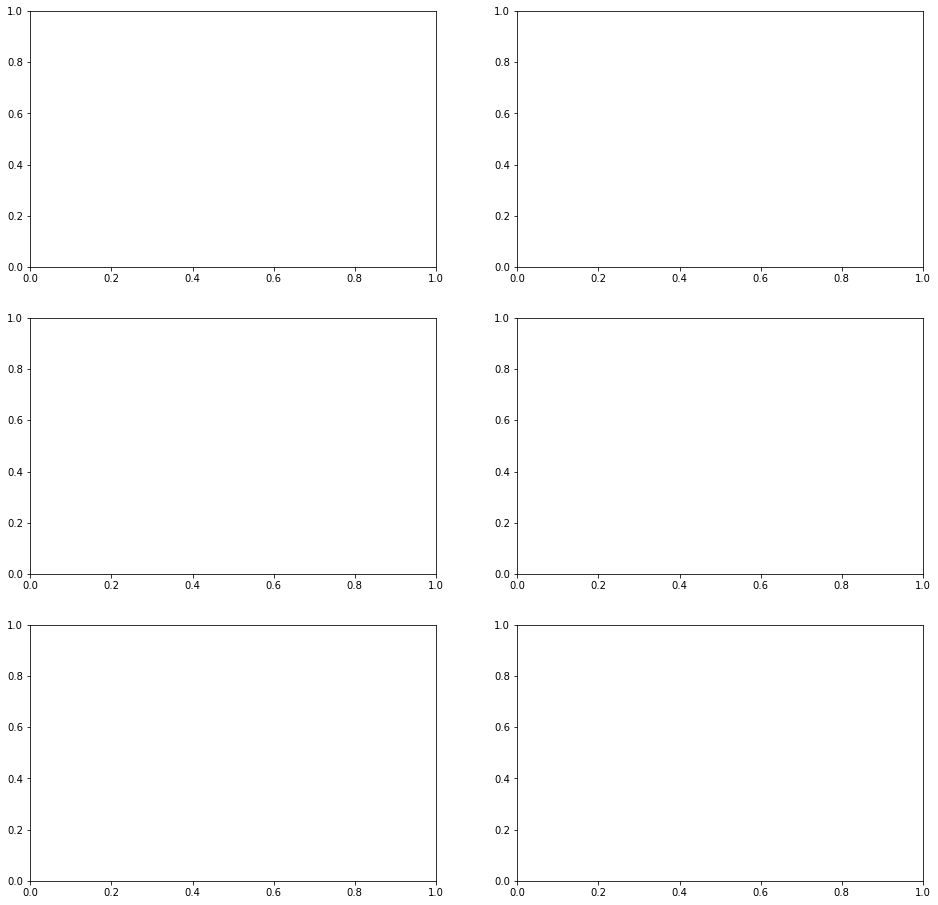

In [17]:
ITERATIONS = 100

def plot_data():
    # Write your code to make 4x4 panel here
    X_LABEL = "Stochastic oracle calls"
    Y_LABEL = "||\u0394f(x)||^2"

    fig, ax = plt.subplots(3,2,figsize=(16,16), sharey=False, sharex=False)

    for i, dataset_name in enumerate(DATASETS[::-1]):
        print(dataset_name)
        sbplt = ax[i%3, i%2]

        for method in METHODS:
            print(method.name)
            gradients = test_method(method, dataset_name, ITERATIONS)
            gradients = [np.linalg.norm(grad, 2) for grad in gradients]
            sbplt.plot(gradients, label=method)

        sbplt.set_xscale('log')
        sbplt.set_title(dataset_name)
        sbplt.set_xlabel(X_LABEL)
        sbplt.set_ylabel(Y_LABEL)
        sbplt.legend(loc='lower left')

        break  # plot single dataset

    fig.tight_layout(pad=2.0)
    # fig.savefig('tests_logistic_regression.jpg', dpi=150)

plot_data()

In [12]:
# METHODS = ['AdaSpider', 'Spider']
# ITERATIONS = 100
#
# def plot_data():
#     # Write your code to make 4x4 panel here
#     X_LABEL = "Stochastic oracle calls"
#     Y_LABEL = "||\u0394f(x)||^2"
#
#     fig, ax = plt.subplots(3,2,figsize=(16,16), sharey=False, sharex=False)
#
#     for i, dataset_name in enumerate(DATASETS):
#         sbplt = ax[i%3, i%2]
#         print(dataset_name)
#         for method in METHODS:
#             if method == "Spider":
#                 spider_params = SpiderParam(100, 5, 0.05)
#                 gradients = test_method(Spider, dataset_name, ITERATIONS, spider_params)
#             else:
#                 gradients = test_method(ADASpider, dataset_name, ITERATIONS)
#             gradients = [np.linalg.norm(grad, 2) for grad in gradients]
#             sbplt.plot(gradients, label=method)
#
#         sbplt.set_xscale('log')
#         sbplt.set_title(dataset_name)
#         sbplt.set_xlabel(X_LABEL)
#         sbplt.set_ylabel(Y_LABEL)
#         sbplt.legend(loc='lower left')
#
#         break  # plot single dataset
#
#     fig.tight_layout(pad=2.0)
#     # fig.savefig('tests_logistic_regression.jpg', dpi=150)
#
# plot_data()